# Dog breeds

Following along http://course.fast.ai/lessons/lesson3.html

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.conv_learner import *

In [5]:
PATH = "data/dogbreed"
SZ = 224
BATCH_SIZE = 48
arch = resnet50

In [6]:
label_csv = os.path.join(PATH, 'labels.csv')
with open(label_csv) as f: n = len(f.readlines()) - 1 # discount header line
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(10222, 2044)

## Initial exploration

In [7]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.tail()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


In [10]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values("id", ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [16]:
tfms = tfms_from_model(arch, SZ, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv,
                                    test_name="test", val_idxs=val_idxs, suffix=".jpg", tfms=tfms, bs=BATCH_SIZE)

In [17]:
fn = os.path.join(PATH, data.trn_ds.fnames[0]); fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

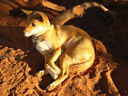

In [37]:
img = PIL.Image.open(fn); img.thumbnail((128, 128)); img

## Initial model

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 216/216 [00:43<00:00,  4.92it/s]


`ps` is probability of dropping a neuron -> regularization & reduce risk of overfitting, see https://www.cs.toronto.edu/%7Ehinton/absps/JMLRdropout.pdf or http://papers.nips.cc/paper/4878-understanding-dropout.pdf

In [20]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.243726   0.635694   0.849804  



[array([0.63569]), 0.8498043014345337]

In [21]:
learn.precompute = False

Now, that `learn.precompute` is `False`, data augmentation can actually kick in.

In [22]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.782115   0.502648   0.862524  
    1      0.684714   0.465946   0.870352                    



[array([0.46595]), 0.87035225060588]

In [25]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.600663   0.434677   0.872309  
    1      0.563217   0.428494   0.869374                    



[array([0.42849]), 0.8693737765580941]

In [26]:
learn.save(f"dogbreed_sz{SZ}")

In [29]:
learn.load(f"dogbreed_sz{SZ}")
learn.unfreeze()
learn.fit([0.5e-4, 0.5e-3, 0.5e-2], 2, cycle_mult=2)

  8%|▊         | 14/171 [00:08<01:34,  1.66it/s, loss=0.752]

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.668317   0.471765   0.8591    
    1      0.557927   0.449511   0.86546                     
    2      0.477699   0.452058   0.858611                    



[array([0.45206]), 0.8586105718304733]

It doesn't look like the validation loss is improving -> back to original model

In [30]:
learn.load(f"dogbreed_sz{SZ}")
learn.freeze()

In [31]:
log_preds,y = learn.TTA(n_aug=8)
probs = np.mean(np.exp(log_preds),0)

In [32]:
accuracy_np(probs, y), sklearn.metrics.log_loss(y, probs)

(0.8884540117416829, 0.4184622922725785)

## Enlarge data

In [48]:
SZ2 = 384
tfms2 = tfms_from_model(arch, SZ2, aug_tfms=transforms_side_on, max_zoom=1.1)
data2 = ImageClassifierData.from_csv(PATH, 'train', label_csv,
                                     test_name="test", val_idxs=val_idxs, suffix=".jpg", tfms=tfms2, bs=BATCH_SIZE)
learn.load(f"dogbreed_sz{SZ}")
learn.freeze()
learn.set_data(data2, precompute=False)

In [49]:
learn.lr_find()

  0%|          | 0/171 [00:00<?, ?it/s]                     


Exception in thread Thread-25:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 87%|████████▋ | 149/171 [03:03<00:27,  1.23s/it, loss=2.82] 


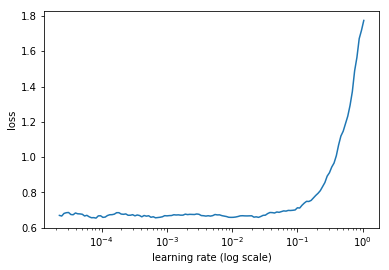

In [50]:
learn.sched.plot()

It doesn't look like any learning rate will make my loss function drop more.  Let's stop here.

## Submitting to Kaggle

Not that my results are so great, but this is a way to learn about the process

In [52]:
learn.load(f"dogbreed_sz{SZ}")
log_preds, y = learn.TTA(is_test=True)

(5, 10357, 120)

In [54]:
probs = np.exp(np.mean(log_preds, 0))
probs.shape

(10357, 120)

In [69]:
ds = pd.DataFrame(probs)
ds.rename({k: v for (k, v) in enumerate(data.classes)}, axis='columns', inplace=True)
ds.insert(0, "id", [os.path.splitext(os.path.basename(f))[0] for f in data.test_ds.fnames])
ds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,0.000526,0.002771,0.002614,0.000851,0.000396,0.003266,0.000700,0.000196,0.000257,...,0.000302,0.000056,0.000765,0.000179,0.000614,0.001053,0.001182,0.003859,0.000425,0.000553
1,6b423ca7020e70eb05732843c5d2bad1,0.000715,0.000191,0.000514,0.000356,0.000252,0.000243,0.000349,0.000211,0.000151,...,0.000033,0.000032,0.000089,0.000057,0.000009,0.000093,0.000639,0.000372,0.000421,0.000071
2,74aa7e201e0e93e13e87b986a7d31839,0.000175,0.000066,0.000113,0.017934,0.000146,0.000083,0.000286,0.001287,0.000141,...,0.000087,0.000301,0.000205,0.000518,0.000011,0.000213,0.000629,0.000269,0.500461,0.000124
3,a079f72193264bc5685e5d28d7372680,0.006542,0.000413,0.003214,0.001741,0.000400,0.002067,0.004036,0.000271,0.000139,...,0.000532,0.000377,0.000446,0.000150,0.000152,0.000340,0.003380,0.000197,0.017218,0.016486
4,583f7580fa5fec1266331fcf83b76fd6,0.000074,0.000133,0.000133,0.000431,0.000034,0.000046,0.000004,0.000008,0.000005,...,0.000020,0.000006,0.000001,0.000007,0.000003,0.000016,0.000070,0.000046,0.000176,0.000009


In [70]:
SUBM = os.path.join(PATH, 'subm')
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(os.path.join(SUBM, 'subm.gz'), compression='gzip', index=False)